# Import

In [1]:
import os 
from pathlib import Path
import cv2 
import numpy as np 
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import albumentations as A

# Configs

In [3]:
class cfg:
    # original dataset variables
    data = Path('./original_dataset')
    bg = data / 'bg'
    obj = data / 'obj'

    # generated dataaset variables
    dataset =  data/ 'dataset'
    
    train = dataset / 'train'
    train_images = train / 'images'
    train_labels = train / 'labels'
    
    test = dataset / 'test'
    test_images = test / 'images'
    test_labels = test / 'labels'

    valid = dataset / 'valid'
    valid_images = valid / 'images'
    valid_labels = valid / 'labels'
    
    # coco dataset variables
    train_annotation =  './dataset/train/_annotations.coco.json'
    train_image_dir = './dataset/train/'

In [8]:
obj_paths = list(cfg.obj.glob('*'))
bg_paths = list(cfg.bg.glob('*'))

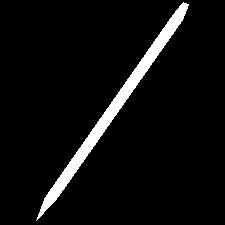

In [9]:
Image.open(obj_paths[3])

In [10]:
cfg.train_image_dir

'./dataset/train/'

# Generate Mask

In [68]:
def generate_mask(ann_file:str="",
                  directory:str=""):
    """generate binary mask from coco annotations

    Args:
        ann_file (str, optional): path to annotation file. Defaults  "". example: 'dataset/train/_annotations.coco.json'
        directory (str, optional): path to image files. Defaults to "". example: 'dataset/train/'
    """
    coco = COCO(ann_file)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for idx in coco.getImgIds():
        img_info = coco.loadImgs(idx)[0]
        img = cv2.imread(directory + img_info['file_name'])
        ann_ids = coco.getAnnIds(imgIds=img_info['id'])
        anns = coco.loadAnns(ann_ids)
        mask = coco.annToMask(anns[0])>0
        for i in range(len(anns)):
            mask += coco.annToMask(anns[i])>0
        print(img_info['file_name'][:-4] )
        mask = mask.astype(np.uint8)*255
        cv2.imwrite(directory + img_info['file_name'][:-4] + '_mask.png', mask)
        
generate_mask('dataset/train/_annotations.coco.json', 'dataset/train/')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
pen_jpg.rf.9881308db5c399000e27452e590d49b8
eraser_jpg.rf.b9a0a57719a8c9a757b0e9ebd6e72bbd
scissors_jpg.rf.b20b41d4b5268fab9d539e2c6aaa8635
ruler_jpg.rf.2ab04ea8e48074a3adffe3d06f8b7392
pencil_jpg.rf.fe4ea28a4dc147a26dd6724b5d3386ba


In [69]:
obj_list = sorted(list(cfg.obj.glob('*.jpg')))
obj_mask_list = sorted(list(cfg.obj.glob('*.png')))
obj_list,obj_mask_list

([PosixPath('original_dataset/obj/eraser.jpg'),
  PosixPath('original_dataset/obj/pen.jpg'),
  PosixPath('original_dataset/obj/pencil.jpg'),
  PosixPath('original_dataset/obj/ruler.jpg'),
  PosixPath('original_dataset/obj/scissors.jpg')],
 [PosixPath('original_dataset/obj/eraser_mask.png'),
  PosixPath('original_dataset/obj/pen_mask.png'),
  PosixPath('original_dataset/obj/pencil_mask.png'),
  PosixPath('original_dataset/obj/ruler_mask.png'),
  PosixPath('original_dataset/obj/scissors_mask.png')])

In [90]:
sample =cv2.imread('original_dataset/bg/2007_000027.jpg')
sample.shape

(500, 486, 3)

In [75]:
mask = cv2.imread('dataset/train/scissors_jpg.rf.b20b41d4b5268fab9d539e2c6aaa8635_mask.png')
# plt.imshow(mask)

(2000, 3000, 3)

In [61]:
def get_img_and_mask(img_path, mask_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
    mask = mask.astype(np.uint8) # This is binary mask
    
    return img, mask

Image file: dataset/train/eraser_jpg.rf.b9a0a57719a8c9a757b0e9ebd6e72bbd.jpg
Mask file: dataset/train/eraser_jpg.rf.b9a0a57719a8c9a757b0e9ebd6e72bbd_mask.png

Shape of the image of the object: (400, 400, 3)
Shape of the binary mask: (400, 400)


Text(0.5, 1.0, 'Binary mask')

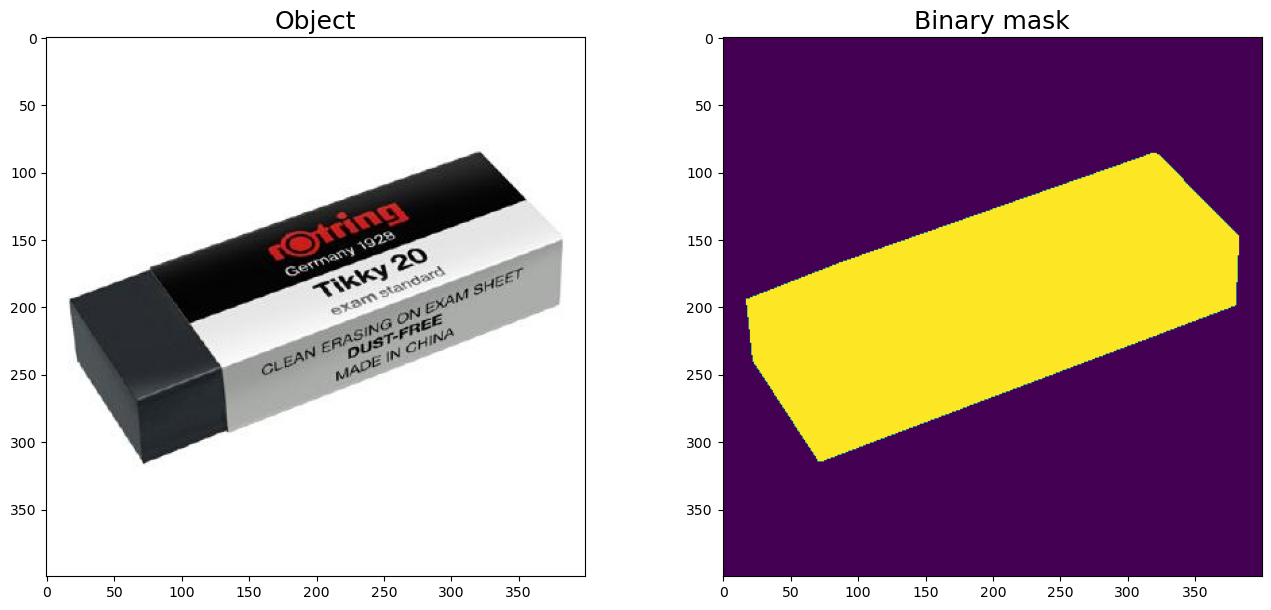

In [62]:
# Let's look at a random object and its binary mask

img_path =  str('dataset/train/eraser_jpg.rf.b9a0a57719a8c9a757b0e9ebd6e72bbd.jpg')
mask_path = str('dataset/train/eraser_jpg.rf.b9a0a57719a8c9a757b0e9ebd6e72bbd_mask.png') 

img, mask = get_img_and_mask(img_path, mask_path)

print("Image file:", img_path)
print("Mask file:", mask_path)
print("\nShape of the image of the object:", img.shape)
print("Shape of the binary mask:", mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Binary mask', fontsize=18)

# Resize Image

In [43]:
def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ])

    transformed = transform_resize(image=img)
    img_r = transformed["image"]
        
    return img_r

Shape of the original background image: (333, 500, 3)
Shape of the resized background image (desired_max=1920, desired_min=None): (1278, 1920, 3)
Shape of the resized background image (desired_max=1920, desired_min=1080): (1080, 1920, 3)


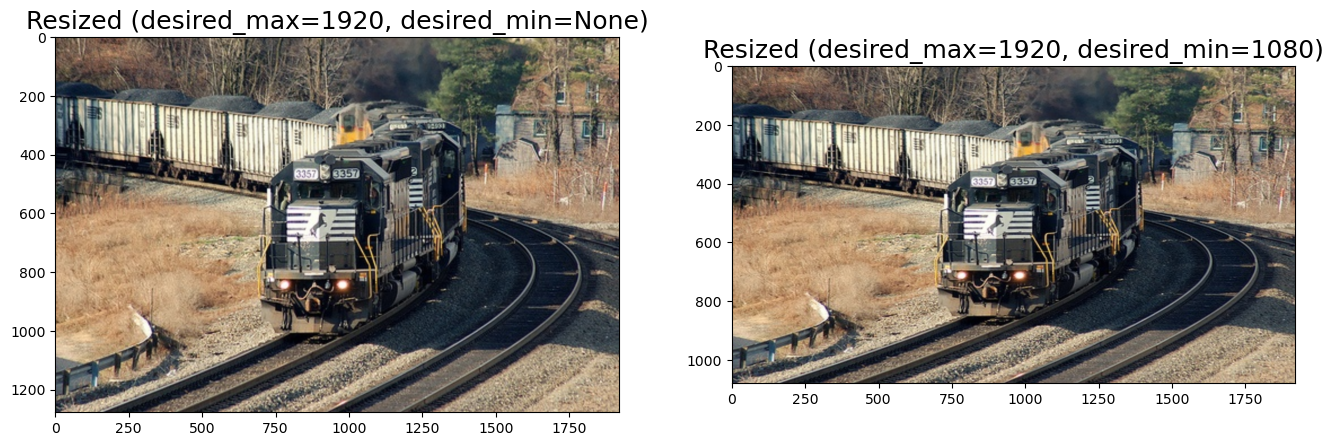

In [44]:
# Let's look how a random background image can be resized with resize_img() function
img_bg_path = str(bg_paths[0])
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_bg_resized_1 = resize_img(img_bg, desired_max=1920, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=1920, desired_min=1080)

print("Shape of the original background image:", img_bg.shape)

print("Shape of the resized background image (desired_max=1920, desired_min=None):", img_bg_resized_1.shape)
print("Shape of the resized background image (desired_max=1920, desired_min=1080):", img_bg_resized_2.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_bg_resized_1)
ax[0].set_title('Resized (desired_max=1920, desired_min=None)', fontsize=18)
ax[1].imshow(img_bg_resized_2)
ax[1].set_title('Resized (desired_max=1920, desired_min=1080)', fontsize=18);

In [45]:
def resize_transform_obj(img, mask, h_new, w_new, perspective=False):
    """resize and trasnform object image and mask for object image

    Args:
        img (numpy array): object image
        mask (numpy array): mask of object image
        h_new (int): _description_
        w_new (int): _description_
        perspective (bool, optional): additional image transform such perspective. Defaults to False.

    Returns:
        tuple(numpy array, numpy array): transformed object image and mask
    """        
    transform_resize = A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]

    transforms = A.Compose([
    A.Perspective(p=1,fit_output=True),
    ])
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t


Shape of the image of the transformed object: (400, 300, 3)
Shape of the transformed binary mask: (400, 300)




Text(0.5, 1.0, 'Transformed binary mask')

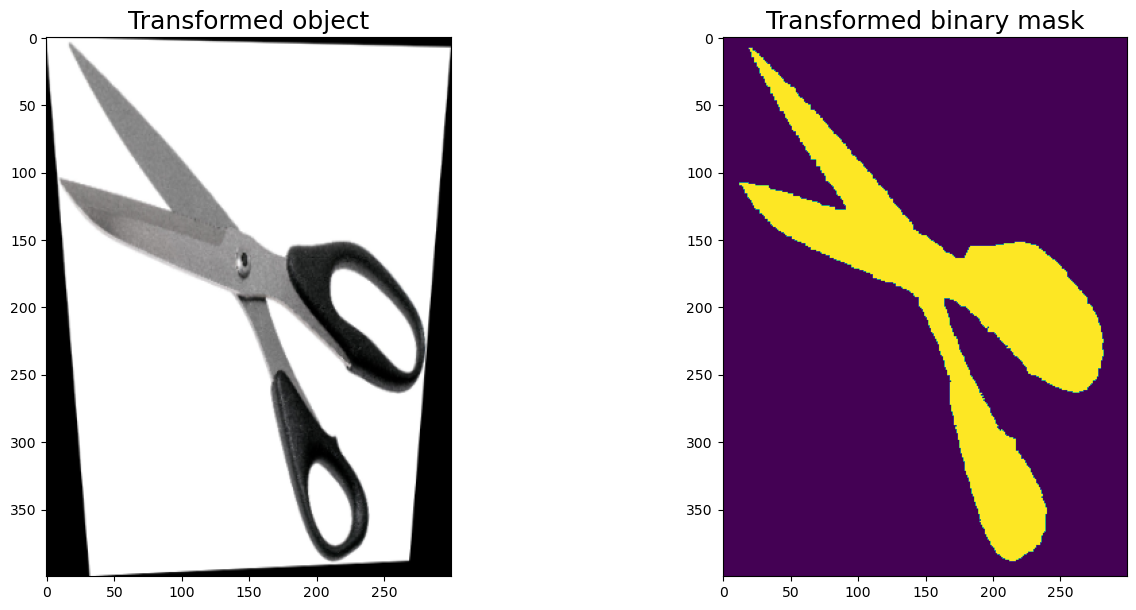

In [63]:
# Let's look how image and binary mask of a random object can be transformed
# with help of resize_transform_obj() function

img_path = str('dataset/train/scissors_jpg.rf.b20b41d4b5268fab9d539e2c6aaa8635.jpg')
mask_path = str('dataset/train/scissors_jpg.rf.b20b41d4b5268fab9d539e2c6aaa8635_mask.png')

img, mask = get_img_and_mask(img_path, mask_path)
# Define the size of the padding

img_t, mask_t = resize_transform_obj(img,
                                     mask,
                                     h_new=400,
                                     w_new=300,
                                     perspective=True
                                     )

print("Shape of the image of the transformed object:", img_t.shape)
print("Shape of the transformed binary mask:", mask_t.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_t)
ax[0].set_title('Transformed object', fontsize=18)
ax[1].imshow(mask_t)
ax[1].set_title('Transformed binary mask', fontsize=18)

# Add Object

In [64]:
def add_obj(img_comp, mask_comp, img, mask, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    img - image of object
    mask - binary mask of object
    x, y - coordinates where center of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_b = mask == 255
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_comp) # h_part - part of the image which gets into the frame of img_comp along y-axis
        w_part = w - max(0, x+w-w_comp) # w_part - part of the image which gets into the frame of img_comp along x-axis

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added

In [65]:
mask_t.shape

(400, 300)

Text(0.5, 1.0, 'Composition mask')

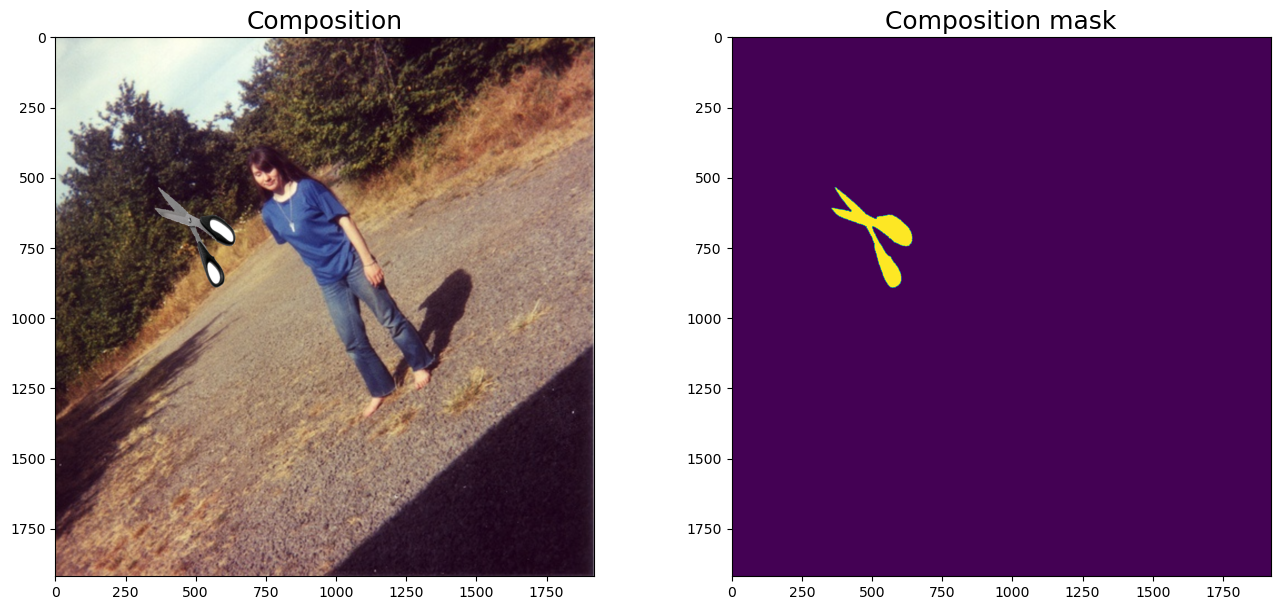

In [66]:
img_bg_path = 'original_dataset/bg/2007_000027.jpg'
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)
img_bg = resize_img(img_bg, desired_max=1920, desired_min=1920)

h, w = img_bg.shape[0], img_bg.shape[1]
mask_comp = np.zeros((h,w), dtype=np.uint8)

img_path = 'original_dataset/obj/eraser.jpg'
mask_path = 'original_dataset/obj/eraser_mask.png'
img_t, mask_t = get_img_and_mask(img_path, mask_path)
img_t, mask_t = resize_transform_obj(img,
                                     mask,
                                     h_new=400,
                                     w_new=300,
                                     perspective=True
                                     )
# img_t, mask_t = remove_obj_background(img_t, mask_t)
img_comp, mask_comp, _ = add_obj(img_bg, mask_comp, img_t, mask_t, x=500, y=700, idx=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18)

In [35]:
np.unique(mask_comp)

array([0], dtype=uint8)

# Generate Dataset

In [67]:
def generated_dataset(object_path:str, 
                      bg_paths:str,
                      save_dir:str,
                      split_ratios=(0.8, 0.1, 0.1),
                      num_images=10,
                      object_range=(1,5)):
    """generate dataset from object and background images

    Args:
        object_path (str): object image path
        bg_paths (str): background image path
        save_dir (str): save directory
        split_ratios (tuple, optional): ratios for train, valid and test. Defaults to (0.8, 0.1, 0.1).
        num_images (int, optional): number of images we want to generate. Defaults to 10.
        object_range (tuple, optional): range of number of objects in image . Defaults to (1,5).
    """
    
    bg_paths = sorted(list(Path(bg_paths).glob('*.jpg')))
    obj_paths = sorted(list(Path(object_path).glob('*.jpg')))
    obj_mask_paths = sorted(list(Path(object_path).glob('*_mask.png')))
    obj_dict = {
        "object_path": obj_paths,
        "object_mask_path": obj_mask_paths
    }
    id2object = {i: str(os.path.basename(obj))[:-4] for i, obj in enumerate(obj_paths)}
    print(id2object)
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    # Split data into train, valid, and test sets
    train_ratio, valid_ratio, test_ratio = split_ratios
    num_train_images = int(num_images * train_ratio)
    num_valid_images = int(num_images * valid_ratio)
    num_test_images = num_images - num_train_images - num_valid_images

    # Create separate directories for train, valid, and test sets
    train_dir = os.path.join(save_dir, "train")
    valid_dir = os.path.join(save_dir, "valid")
    test_dir = os.path.join(save_dir, "test")

    os.makedirs(os.path.join(train_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(train_dir, "labels"), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, "labels"), exist_ok=True)
    os.makedirs(os.path.join(test_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(test_dir, "labels"), exist_ok=True)

    # Generate the dataset
    for i in range(num_images):
        # Randomly select a background image
        bg_path = np.random.choice(bg_paths)
        bg = cv2.imread(str(bg_path))
        bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
        bg = resize_img(bg, desired_max=1920, desired_min=1920)
        mask_comp = np.zeros((bg.shape[0], bg.shape[1]), dtype=np.uint8)

        round_range = np.random.randint(object_range[0], object_range[1]+1)
        classes = []
        for round in range(round_range):

            # Randomly select an object image and its mask
            obj_idx = np.random.choice(len(obj_dict["object_path"]))
            classes.append(obj_idx) # add the class to the list
            obj_path = obj_dict["object_path"][obj_idx]
            mask_path = obj_dict["object_mask_path"][obj_idx]
            obj, mask = get_img_and_mask(str(obj_path), str(mask_path))

            # Resize and transform the object image and its mask
            # Generate random height and width within a range
            h_new = np.random.randint(300, 800)
            w_new = np.random.randint(300, 800)
            obj, mask = resize_transform_obj(obj, mask, h_new=h_new, w_new=w_new, perspective=True)
            
            # Add the object to the background image
            x = np.random.randint(0,bg.shape[1]) 
            y = np.random.randint(0,bg.shape[0])
            img_comp, mask_comp, _ = add_obj(bg, mask_comp, obj, mask, x=x, y=y, idx=round+1)
            
        # Save the composition and its label
        if i < num_train_images:
            save_path = os.path.join(train_dir, "images", f"Image{i}.jpg")
            label_save_path = os.path.join(train_dir, "labels", f"Label{i}.txt")
        elif i < num_train_images + num_valid_images:
            save_path = os.path.join(valid_dir, "images", f"Image{i}.jpg")
            label_save_path = os.path.join(valid_dir, "labels", f"Label{i}.txt")
        else:
            save_path = os.path.join(test_dir, "images", f"Image{i}.jpg")
            label_save_path = os.path.join(test_dir, "labels", f"Label{i}.txt")

        cv2.imwrite(save_path, cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR))

        # write the label file
        # Get the unique values in the mask (excluding the background)
        unique_values = np.unique(mask_comp)[1:]
        bounding_boxes = []

        # Iterate over the unique values
        for value in unique_values:
            # Create a binary mask for the current object
            object_mask = np.where(mask_comp == value, 1, 0).astype(np.uint8)
            # Convert the mask to grayscale
            # object_mask = cv2.cvtColor(object_mask, cv2.COLOR_BGR2GRAY)
            # Bounding Box
            bbox = [0, 0, 0, 0]
            # Find where the mask is not zero
            rows = np.any(object_mask, axis=1)
            cols = np.any(object_mask, axis=0)

            # Find the minimum and maximum row and column indices
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]

            bbox = [x_min, x_max, y_min, y_max]
            bounding_boxes.append(bbox)

        print(save_path,bounding_boxes, classes)
        # Write the bounding boxes to the label file
        with open(label_save_path, 'w') as f:
            for i, box in enumerate(bounding_boxes):
                x1, y1 = box[0], box[2]
                x2, y2 = box[1], box[2]
                x3, y3 = box[1], box[3]
                x4, y4 = box[0], box[3]
                f.write(f"{classes[i]} {x1} {y1} {x2} {y2} {x3} {y3} {x4} {y4}\n")



generated_dataset(cfg.obj, cfg.bg,cfg.dataset, num_images=20)

{0: 'eraser', 1: 'pen', 2: 'pencil', 3: 'ruler', 4: 'scissors'}
original_dataset/dataset/train/images/Image0.jpg [[887, 922, 591, 898], [728, 978, 0, 619], [767, 1236, 128, 285], [1292, 1919, 540, 812], [1644, 1919, 1388, 1759]] [1, 2, 3, 0, 4]
original_dataset/dataset/train/images/Image1.jpg [[132, 654, 0, 489], [151, 417, 1680, 1777], [373, 418, 401, 794], [721, 1260, 305, 682], [1577, 1919, 0, 282]] [4, 3, 1, 0, 4]
original_dataset/dataset/train/images/Image2.jpg [[0, 427, 1392, 1919], [0, 135, 0, 149], [610, 965, 1282, 1683], [1353, 1919, 1443, 1582]] [2, 2, 2, 3]
original_dataset/dataset/train/images/Image3.jpg [[728, 1285, 1610, 1878], [0, 449, 74, 151]] [0, 3]
original_dataset/dataset/train/images/Image4.jpg [[1391, 1690, 962, 1099]] [3]
original_dataset/dataset/train/images/Image5.jpg [[377, 795, 1423, 1870], [1083, 1761, 0, 276], [956, 1165, 1572, 1862]] [4, 0, 2]
original_dataset/dataset/train/images/Image6.jpg [[1558, 1919, 676, 1326]] [2]
original_dataset/dataset/train/imag

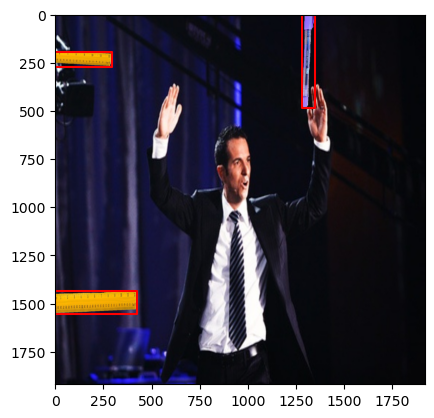

In [69]:
import matplotlib.pyplot as plt
import cv2

def plot_image_and_boxes(image_path, bounding_box_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load the bounding box data
    bounding_boxes = []
    with open(bounding_box_path, 'r') as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])
            x1, y1, x2, y2, x3, y3, x4, y4 = map(int, data[1:])
            bounding_boxes.append(((x1, y1), (x2, y2), (x3, y3), (x4, y4)))

    # Plot the image and bounding boxes
    fig, ax = plt.subplots()
    ax.imshow(image)

    for bbox in bounding_boxes:
        x = [bbox[0][0], bbox[1][0], bbox[2][0], bbox[3][0], bbox[0][0]]
        y = [bbox[0][1], bbox[1][1], bbox[2][1], bbox[3][1], bbox[0][1]]
        ax.plot(x, y, color='red')

    plt.show()
plot_image_and_boxes('original_dataset/dataset/train/images/Image14.jpg', 'original_dataset/dataset/train/labels/Label14.txt')